# Relation between count and point processes

### Table of contents

1. [**SVGP**](#svgp)
3. [**SSGP**](#ssgp)
4. [**STGP**](#stgp)


This notebook contains code for:
- Investigating the number of inducing points and expressivity, degree of nonconvexity of GP models
- Multi-regressor tuning evaluation
- GP-GLM validation in population fitting
- GP marginal log-likelihood versus locally weighted log-likelihood model selection for kernel hyperparameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr


import gaussneuro as gn


import matplotlib.pyplot as plt

/var/home/dl543/Documents/Learning/GaussNeuro/examples/../gaussneuro/filters/FIR.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
#jax.config.update("jax_enable_x64", True)

<a id='models_IPP'></a>
### 5.3 Rate-rescaled renewal processes

In [49]:
def get_renewal(renewal_type, neurons, dt):
    if renewal_type == 'gamma':
        alpha = np.linspace(0.5, 1.5, neurons)
        renewal = gn.likelihoods.renewal.Gamma(
            neurons,
            dt,
            alpha,
        )

    elif renewal_type == 'lognorm':
        sigma = np.linspace(0.5, 0.5, neurons)
        renewal = gn.likelihoods.renewal.LogNormal(
            neurons,
            dt,
            sigma,
        )

    elif renewal_type == 'invgauss':
        mu = np.linspace(0.5, 1.5, neurons)
        renewal = gn.likelihoods.renewal.InverseGaussian(
            neurons,
            dt,
            mu,
        )
        
    elif renewal_type == 'exponential':
        renewal = gn.likelihoods.renewal.Exponential(
            neurons,
            dt,
        )
    
    return renewal

[autoreload of gaussneuro.likelihoods.renewal failed: Traceback (most recent call last):
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to fi

In [50]:
obs_dims = 3
dt = 1.

rm = get_renewal('lognorm', obs_dims, dt)

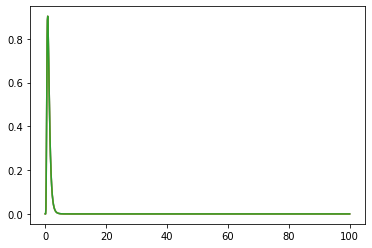

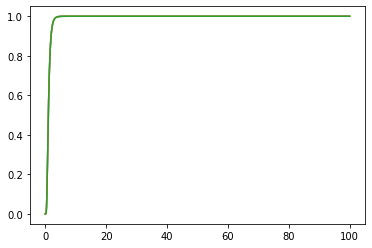

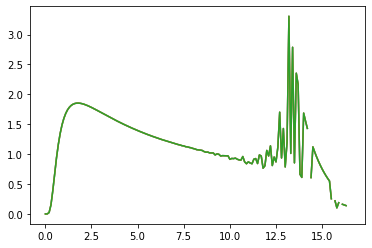

In [51]:
ISI = jnp.linspace(0.001, 100., 1000)[:, None]

ll = jax.vmap(rm.log_density)(ISI)
plt.plot(ISI[:, 0], np.exp(ll)[:, :])
plt.show()

cd = jax.vmap(rm.cum_density)(ISI)
plt.plot(ISI[:, 0], cd[:, :])
plt.show()

lh = jax.vmap(rm.log_hazard)(ISI)
plt.plot(ISI[:, 0], jnp.exp(lh[:, :]))
plt.show()

In [ ]:
def cmap_arrow(
    ax,
    start,
    end,
    cmap,
    n_segments=50,
    lw=3,
    head_size=10,
    head_width=0.8,
    head_length=0.5,
):
    """ """

    # Arrow shaft: LineCollection
    x = np.linspace(start[0], end[0], n_segments)
    y = np.linspace(start[1], end[1], n_segments)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=lw)
    lc.set_array(np.linspace(0, 1, n_segments))
    ax.add_collection(lc)

    # Arrow head: Triangle
    tricoords = [
        (0, -head_width / 2.0),
        (head_length, 0),
        (0, head_width / 2.0),
        (0, -head_width / 2.0),
    ]
    angle = np.arctan2(end[1] - start[1], end[0] - start[0])
    rot = mtransforms.Affine2D().rotate(angle)
    tricoords2 = rot.transform(tricoords)
    tri = mpath.Path(tricoords2, closed=True)
    ax.scatter(
        end[0], end[1], c=1, s=(2 * head_size) ** 2, marker=tri, cmap=cmap, vmin=0
    )
    
    
    
def plot_dispersion(ax, q_cdf, s_KS, labelx=False, labely=False):
    """
    KS-plot for visualizing dispersion structure.

    :param string mode: either `count` or `ISI` version of quantiles
    """
    bins = np.linspace(0.0, 1.0, 11)
    q_order = np.append(np.array([0]), np.sort(q_cdf))

    samples = len(q_cdf)
    bb = np.arange(0, samples + 1) / samples
    (line,) = ax.plot(bb, bb, "r--")
    ax.fill_between(
        bins,
        bins - s_KS * np.ones_like(bins),
        bins + s_KS * np.ones_like(bins),
        color="grey",
        alpha=0.5,
    )
    (line,) = ax.plot(q_order, bb, "b")

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)

    decorate_ax(ax)

    if labelx:
        ax.set_xticks([0, 1])
    if labely:
        ax.set_yticks([0, 1])

    return ax

In [51]:
t_eval = jnp.linspace(0, 10, 100)
x_cond = jnp.zeros((2, f_dims, x_dims))

renewal_density = mrp_model.obs_model.sample_conditional_ISI(
    prng_state, t_eval, x_cond, jitter, num_samps = 20, prior = True)

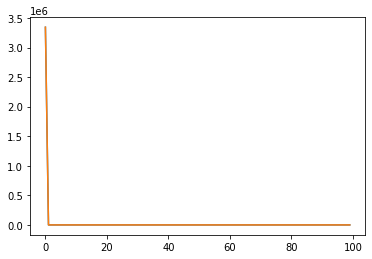

In [52]:
s = 0
n = 0

plt.plot(renewal_density[:, n, :].T)

### Adding counts

In [ ]:
# Turn into count process
sim_tbin = 0.001
sim_samples = 1000
trials = 10000
gg = []

rate = np.empty((trials, sim_samples))

rate[:, :] = 5.0
#rate[:, :sim_samples//2] = 100.0
#rate[:, sim_samples//2:] = 0.0

mode = 'gamma'
if mode == 'gamma':
    shape = 0.5
    renew = mdl.point_process.ISI_gamma(shape)
elif mode == 'invgauss':
    mu = 1.
    lambd = 1.
    renew = mdl.point_process.ISI_invGauss(mu, lambd)
elif mode == 'lognorm':
    mu = 0.1
    sigma = 1.
    renew = mdl.point_process.ISI_logNormal(mu, sigma)
    
s = mdl.point_process.gen_IRP(renew, rate[:, None], sim_tbin)
for k in range(len(s)):
    gg.append(len(s[k]))
    
    
ggg = []
rate[:, :] = 5.0
#rate[:, :sim_samples//2] = 100.0
#rate[:, sim_samples//2:] = 0.0

mode = 'gamma'
if mode == 'gamma':
    shape = 0.5
    renew = mdl.point_process.ISI_gamma(shape)
elif mode == 'invgauss':
    mu = 1.
    lambd = 1.
    renew = mdl.point_process.ISI_invGauss(mu, lambd)
elif mode == 'lognorm':
    mu = 0.1
    sigma = 1.
    renew = mdl.point_process.ISI_logNormal(mu, sigma)
    
s = mdl.point_process.gen_IRP(renew, rate[:, None], sim_tbin)
for k in range(len(s)):
    ggg.append(len(s[k]))



In [ ]:
gggg = []
for h in range(len(gg)):
    gggg.append(gg[h]+ggg[h])

fig, ax = plt.subplots()
bins = np.arange(50)
prbs = stats.gamma_count_prob(bins, 10.0, shape, sim_tbin*sim_samples)
ax.plot(bins, prbs, 'r--', label=r'theory ($\alpha$={})'.format(shape))
ax.hist(gg, bins=np.arange(50)-0.5, density=True, label='simulation')
ax.legend()
ax.set_xlabel('Spike count')
ax.set_ylabel('Probability')
plt.show()

fig, ax = plt.subplots()
bins = np.arange(100)
prbs = stats.gamma_count_prob(bins, 5.0, shape, sim_tbin*sim_samples)
ax.plot(bins, prbs, 'r--', label=r'theory ($\alpha$={})'.format(shape))
ax.hist(ggg, bins=np.arange(100)-0.5, density=True, label='simulation')
ax.legend()
ax.set_xlabel('Spike count')
ax.set_ylabel('Probability')
plt.show()

fig, ax = plt.subplots()
bins = np.arange(100)
prbs = stats.gamma_count_prob(bins, 15.0, shape, sim_tbin*sim_samples)
ax.plot(bins, prbs, 'r--', label=r'theory ($\alpha$={})'.format(shape))
ax.hist(gggg, bins=np.arange(100)-0.5, density=True, label='simulation')
ax.legend()
ax.set_xlabel('Spike count')
ax.set_ylabel('Probability')
plt.show()

In [ ]:
# count statistics
def gamma_count_prob(n, rate, shape, sim_time):
    """
    Evaluate count data against the Gamma renewal process count distribution:
    .. math:: p(n) = .
    :param numpy.array alpha: Probabilities of the discrete target distribution. The 
        shape of the array dimensions is (samples, index) with index size :math:`n`.
    :returns: Samples from the Gumbel-softmax indexed from :math:`0` to :math:`n-1`
    :rtype: numpy.array
    """
    g = rate*sim_time
    if g == 0: # will get Gamma(0)*0 which is ~0/0 so manually set to 1
        return (n == 0).astype(float)
    
    return sps.gammainc(shape*n, g) - sps.gammainc(shape*(n+1), g)

### Inhomogenous Gamma process

The inhomogeneous Gamma point process likelihood with rate $\lambda(t)$ is 
\begin{equation}
    p(t_1, \ldots, t_n) = \frac{\Gamma(\alpha, \Lambda(t_1)) \Gamma(\alpha, \Lambda(t_n))}{\Gamma(\alpha)^n} \cdot \left[ \prod_{i=1}^n \lambda(t_i) \right] \cdot \left[ \prod_{i=2}^n(\Lambda(t_i) - \Lambda(t_{i-1}))^{\alpha-1} \right] \cdot e^{-(\Lambda(t_n) - \Lambda(t_1))}
\end{equation}
where $\Lambda(t) = \int_0^t \lambda(\tau) \mathrm{d}\tau$ and $\Gamma(\alpha, x)$ denotes the regularized upper incomplete Gamma function. It satisfies $\Gamma(\alpha, x) = 1 - G(\alpha, x)$ with 
\begin{equation}
G(\alpha n, \lambda T) = \frac{1}{\Gamma(n\alpha)} \int_0^T \lambda^{n\alpha} \tau^{n\alpha - 1} e^{-\lambda \tau} \cdot \mathrm{d}\tau
\end{equation}
called the regularized lower incomplete Gamma function. The Gamma count process probability is given by 
\begin{equation}
    Pr(N_T = n) = G(\alpha n, \lambda T) - G(\alpha (n+1), \lambda T)
\end{equation}
This distribution has $\mathbb{E}[N_T] = \sum_{k=1}^{\infty} G(\alpha k, \lambda T)$.

Let us consider the interspike intervals (ISIs), which are drawn from $Gamma(\tau|\alpha,\lambda)$. The derivation for $Pr(N_T = n)$ can then be seen intuitively using the fact that $\tau_1 + \tau_2 \sim Gamma(\tau|\alpha_1 + \alpha_2,\lambda)$. The first term is thus the probability that $n$ ISIs have a total sum below $T$, while the second term is the probability adding another ISI goes over the counting interval $T$. Note that except for the case $\alpha = 1$ (exponential distribution), $\mathbb{E}[\tau]^{-1} \neq \mathbb{E}[N_T]$. Hence the rate parameter appearing in $\mathbb{E}[\tau] = \frac{\alpha}{\lambda}$ cannot be interpreted as the 'rate' similar to the Poisson point process.

The occupancy normalized histograms used to provide a non-parametric estimate of place fields are equivalent to calculating the point estimate of $\mathbb{E}[N_T]$ for $T=1$, which by the above analysis shows this generally is a biased estimator of the underlying $\mathbb{E}[\tau]^{-1} = \frac{\lambda}{\alpha}$ in that bin. However, numerically the values are close over a wide range of $\alpha$. The differences are noticeable below $\alpha \approx 0.82$ when the bias is $>0.1$, with positive bias showing that naively using occupancy normalized histograms compensated by the shape overestimates the actual rate.

Additionally, we assumed $\mathbb{E}[N_{T_1}] + \mathbb{E}[N_{T_2}] = \mathbb{E}[N_{T_1+T_2}]$, which only holds approximately for Gamma count processes. We need $T \gg \frac{\alpha}{\lambda}$ in order to be able to ignore the effects of the renewal point process at the bin edges.

In [ ]:
rate = 10.0
shape = 0.5

fig = plt.figure(figsize=(8,4))
gs1 = fig.add_gridspec(nrows=1, ncols=2, wspace=0.2, bottom=0.6, top=0.95)
ax = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])


bins = np.arange(31)
prbs = stats.gamma_count_prob(bins, rate, 1.0, 1.0)
ax.plot(bins, prbs, color='r', label=r'Poisson')
shape = 0.5
prbs2 = stats.gamma_count_prob(bins, rate*shape, 1.0, shape)
ax.bar(bins, prbs2, width=1, color='cyan', edgecolor='grey', linewidth=1)
ax.set_xlim(-0.5, 30.5)
ax.set_yticks([])
ax.set_ylabel('probability')
ax.legend()

ax.text(-0.18, 1.05, 'A', transform=ax.transAxes, size=15)#, weight='bold') # string.ascii_uppercase[n]
ax.text(0.25, 0.1, r'$\alpha=\frac{1}{2}$', transform=ax.transAxes, size=12)


prbs = stats.gamma_count_prob(bins, rate, 1.0, 1.0)
ax2.plot(bins, prbs, color='r')
shape = 2.0
prbs2 = stats.gamma_count_prob(bins, rate*shape, 1.0, shape)
ax2.bar(bins, prbs2, width=1, color='cyan', edgecolor='grey', linewidth=1)
ax2.set_xlim(-0.5, 30.5)
ax2.set_yticks([])

fig.text(-0.12, -0.28, 'spike count', transform=ax2.transAxes, fontsize=12, ha='center')
ax2.text(0.25, 0.1, r'$\alpha=2$', transform=ax2.transAxes, size=12)


gs2 = fig.add_gridspec(nrows=1, ncols=3, wspace=0.4, bottom=0.05, top=0.45)
ax = fig.add_subplot(gs2[0, 0])
ax2 = fig.add_subplot(gs2[0, 1:])

# checking correspondence of ISI average to count average
eps = 5*1e-2
alpha_arr = np.linspace(0.2, 3.0, 1000)
beta = 100.0

avg_count = []
avg_invISI = []
for alpha in alpha_arr:
    h = 0
    add = 1
    n = 1
    while add > 1e-4:
        add = sps.gammainc(alpha*n, beta)
        h += add
        n += 1
    avg_count.append(h)
    avg_invISI.append(beta/alpha)
        
ax.text(-0.3, 1.0, 'B', transform=ax.transAxes, size=15)
ax.plot(alpha_arr, np.array(avg_count), label=r'$\mathbb{E}[N]$')
ax.plot(alpha_arr, np.array(avg_invISI), 'r--', label=r'$\mathbb{E}[\tau]^{-1}$')
ll = np.linspace(0, 6.9, 10)
ax.plot(np.ones_like(ll), ll, color='#dddddd')

ax.legend(frameon=False)
#ax.set_xlim(0.2, 3.0)
#ax.set_xticks([0.2, 1.0, 2.0])
#ax.set_ylim(0.0, 6.9)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('count')



# Spike trains
ax2.text(-0.15, 1.0, 'C', transform=ax2.transAxes, size=15)

trials = 5
sim_samples = 1000
sim_tbin = 0.001 # s
rate = np.empty((trials, 1, sim_samples))

rate.fill(5.0)
dist_isi = mdl.point_process.ISI_gamma(0.25)
s = mdl.point_process.gen_IRP(dist_isi, rate, sim_tbin)
for t in range(trials):
    s_ = s[t]
    ax2.scatter(s_*sim_tbin, np.ones_like(s_)*t, marker='|', color='b', s=40, 
                label=r'$\alpha=\frac{1}{4}$')

rate.fill(20.0)
dist_isi = mdl.point_process.ISI_gamma(1)
s = mdl.point_process.gen_IRP(dist_isi, rate, sim_tbin)
for t in range(trials):
    s_ = s[t]
    ax2.scatter(s_*sim_tbin, np.ones_like(s_)*(t+trials+1), marker='|', s=40, color='k', 
                label=r'$\alpha=1$')

rate.fill(80.0)
dist_isi = mdl.point_process.ISI_gamma(4)
s = mdl.point_process.gen_IRP(dist_isi, rate, sim_tbin)
for t in range(trials):
    s_ = s[t]
    ax2.scatter(s_*sim_tbin, np.ones_like(s_)*(t+2*trials+2), marker='|', s=40, color='g', 
                label=r'$\alpha=4$')
    
ll = np.linspace(.0, 1., 10)
ax2.plot(ll, np.ones_like(ll)*(trials), color='grey')
ax2.plot(ll, np.ones_like(ll)*(2*trials+1.), color='grey')

ax2.set_xlabel('time (s)')
ax2.set_ylim(-1.5, trials*3+0.5 + 2)
ax2.set_xlim(0.0, 1.0)

ax2.set_yticks([2, 8, 14])
ax2.set_yticklabels([r'$\alpha=\frac{1}{4}$  ', r'$\alpha=1$  ', r'$\alpha=4$  '])
ax2.tick_params(axis='y', which='both', length=0)

ax2.spines['left'].set_visible(False)


#plt.savefig('output/gamma_process.svg')
#plt.savefig('output/gamma_process.pdf')
plt.show()